<a href="https://colab.research.google.com/github/jxb5778/topic_modeling/blob/master/VAE_Topic_Model_20_News_Group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from sklearn.datasets import fetch_20newsgroups


data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)

In [ ]:
print(len(data))

11314


In [ ]:
print(data[10])

Archive-name: graphics/resources-list/part1
Last-modified: 1993/04/17


Computer Graphics Resource Listing : WEEKLY POSTING [ PART 1/3 ]
Last Change : 17 April 1993

Many FAQs, including this Listing, are available on the archive site
pit-manager.mit.edu (alias rtfm.mit.edu) [18.172.1.27] in the directory
pub/usenet/news.answers.  The name under which a FAQ is archived appears
in the Archive-name line at the top of the article.
This FAQ is archived as graphics/resources-list/part[1-3]

There's a mail server on that machine. You send a e-mail message to
mail-server@pit-manager.mit.edu  containing the keyword "help" (without
quotes!) in the message body.

You can see in many other places for this Listing. See the item:

0. Places to find the Resource Listing

for more information.

Items Changed:
--------------

RE-ARRANGED the subjects, in order to fir better in the 63K/article limit.
I PLAN ON CHANGING HEADERS SOON, SO BE CAREFUL! ONLY THE "Resource Listing"
keys are sure to remain in 

In [ ]:
import nltk
from nltk import word_tokenize       
from nltk.corpus import stopwords   
from nltk.stem import WordNetLemmatizer 

import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
class LemmaTokenizer(object):
    def __init__(self, token_pattern=r"(?u)\b\w\w+\b", stop='english'):
        self.wnl = WordNetLemmatizer()
        self.token_pattern = re.compile(token_pattern)
        self.stop = set(stopwords.words('english'))
        
    def __call__(self, doc):
        return [
                self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if len(t) > 2 
                and re.match("[a-z].*",t) 
                and re.match(self.token_pattern, t) 
                and t not in self.stop
                ]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vocab_size = 15000

tokenizer = LemmaTokenizer()

vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=LemmaTokenizer(),
                             max_features=vocab_size,
                             max_df=0.95, 
                             min_df=5)

vectors = vectorizer.fit_transform(data)
vectors = vectors.toarray()
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))


vocab size: 13538


In [ ]:
if vocab_size > len(vocab_list):
  vocab_size = len(vocab_list)
vocab_size

13538

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 20
batch_size=100
input_shape = (batch_size, vocab_size)

initializer = tf.keras.initializers.GlorotNormal()

encoder_inputs = keras.Input(batch_shape=input_shape)

h = layers.Dense(500, activation="softmax", kernel_initializer=initializer)(encoder_inputs)
h = layers.Dense(500, activation="softmax")(h)
h = layers.Dense(500, activation="softmax")(h)

z_mean = layers.BatchNormalization()(layers.Dense(latent_dim, name="z_mean", activation='sigmoid')(h))
z_log_var = layers.BatchNormalization()(layers.Dense(latent_dim, name="z_log_var", activation='sigmoid')(h))
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(100, 13538)]       0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (100, 500)           6769500     input_11[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (100, 500)           250500      dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (100, 500)           250500      dense_25[0][0]                   
____________________________________________________________________________________________

In [ ]:
initializer_decode = tf.keras.initializers.GlorotNormal()

latent_inputs = keras.Input(shape=(latent_dim,))

"""
h_decode = layers.Dense(128, activation="softmax", kernel_initializer=initializer_decode)(latent_inputs)
h_decode = layers.BatchNormalization()(h_decode)
h_decode = layers.Dropout(0.2)(h_decode)

h_decode = layers.Dense(256, activation="softmax", kernel_initializer=initializer_decode)(h_decode)
h_decode = layers.BatchNormalization()(h_decode)
h_decode = layers.Dropout(0.2)(h_decode)
"""

h_decode = layers.Dense(500, activation="softplus", kernel_initializer=initializer_decode)(latent_inputs)
h_decode = layers.BatchNormalization()(h_decode)

decoder_outputs = layers.Dense(vocab_size, activation="softplus")(h_decode)
decoder_outputs = layers.BatchNormalization()(decoder_outputs)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_22 (Dense)             (None, 500)               10500     
_________________________________________________________________
batch_normalization_22 (Batc (None, 500)               2000      
_________________________________________________________________
dense_23 (Dense)             (None, 13538)             6782538   
_________________________________________________________________
batch_normalization_23 (Batc (None, 13538)             54152     
Total params: 6,849,190
Trainable params: 6,821,114
Non-trainable params: 28,076
_________________________________________________________________


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1, gamma=0.2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.gamma = gamma

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )

            reconstruction_loss *= len(data)

            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5*self.beta
            kl_loss = tf.math.maximum(self.gamma, kl_loss)

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
vae = VAE(encoder, decoder, beta=50, gamma=0.2)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
vectors = vectors[:11300]

In [ ]:
len(vectors)

11300

In [ ]:
history = vae.fit(vectors, verbose=1, batch_size=batch_size, epochs=25)

Epoch 1/25
113/113 [==============================] - 21s 183ms/step - loss: 14.2267 - reconstruction_loss: 7.9266 - kl_loss: 6.3001
Epoch 2/25
113/113 [==============================] - 21s 182ms/step - loss: 6.6106 - reconstruction_loss: 4.4901 - kl_loss: 2.1205
Epoch 3/25
113/113 [==============================] - 21s 182ms/step - loss: 5.1131 - reconstruction_loss: 4.5011 - kl_loss: 0.6119
Epoch 4/25
113/113 [==============================] - 21s 183ms/step - loss: 4.7838 - reconstruction_loss: 4.5740 - kl_loss: 0.2098
Epoch 5/25
113/113 [==============================] - 21s 182ms/step - loss: 4.8194 - reconstruction_loss: 4.6194 - kl_loss: 0.2000
Epoch 6/25
113/113 [==============================] - 21s 182ms/step - loss: 4.8784 - reconstruction_loss: 4.6784 - kl_loss: 0.2000
Epoch 7/25
113/113 [==============================] - 21s 182ms/step - loss: 4.8828 - reconstruction_loss: 4.6828 - kl_loss: 0.2000
Epoch 8/25
113/113 [==============================] - 21s 183ms/step - loss

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])


<Figure size 432x288 with 0 Axes>

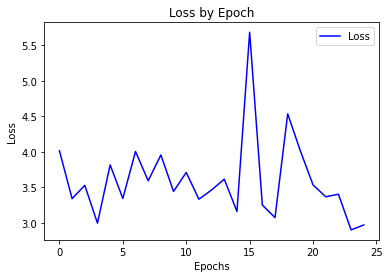

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

zoom = 0
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[zoom:], loss[zoom:], 'b')

plt.title('Loss by Epoch')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
for weight in vae.get_weights():
  print(weight.shape)

(13538, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 20)
(20,)
(500, 20)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20, 500)
(500,)
(500,)
(500,)
(500,)
(500,)
(500, 13538)
(13538,)


In [ ]:
weights = vae.get_weights()[-8]

weights = np.dot(weights, vae.get_weights()[-2])
#weights = np.dot(weights, vae.get_weights()[-12])
#weights = np.dot(weights, vae.get_weights()[-6])

print(weights.shape)

(20, 13538)


In [ ]:
exp_beta = np.exp(weights).T
phi = (exp_beta/np.sum(exp_beta, axis=0)).T

In [ ]:
for k, phi_k in enumerate(phi):
    print('topic: {}'.format(k))
    for w in np.argsort(phi_k)[::-1][:10]:
        print(vocab_list[w], phi_k[w])
    print()

topic: 0
team 8.434945e-05
nhl 8.2969615e-05
player 8.275925e-05
minor 8.269926e-05
hockey 8.249522e-05
season 8.242834e-05
encrypted 8.2270235e-05
militia 8.195109e-05
clipper 8.1844526e-05
enforcement 8.171746e-05

topic: 1
incredible 8.1463644e-05
corson 8.096859e-05
organized 8.0883874e-05
tartar 8.049346e-05
ottoman 8.0444304e-05
tatar 8.032681e-05
fpu 8.020355e-05
dip 7.9964826e-05
condescending 7.978361e-05
adcom 7.9647645e-05

topic: 2
atheism 8.950598e-05
atheist 8.559207e-05
wip 8.1552695e-05
adobe 8.1208564e-05
religious 8.114154e-05
behaviour 8.047112e-05
linked 8.033545e-05
decenso 8.005109e-05
com 7.996098e-05
allocation 7.985124e-05

topic: 3
dod 8.2500526e-05
jpeg 8.07845e-05
natural 8.018998e-05
tracer 7.991967e-05
king 7.9897225e-05
block 7.9849044e-05
converter 7.983058e-05
denizen 7.979128e-05
wrist 7.9751044e-05
one 7.96627e-05

topic: 4
book 8.573896e-05
search 8.2724066e-05
crime 8.257726e-05
gun 8.201692e-05
turkey 8.198976e-05
pin 8.179051e-05
faith 8.1240614e-

In [ ]:
!pip install tmtoolkit

     |████████████████████████████████| 19.9MB 219kB/s 
     |████████████████████████████████| 1.4MB 53.0MB/s 
     |████████████████████████████████| 2.3MB 48.1MB/s 
     |████████████████████████████████| 112kB 58.2MB/s 
     |████████████████████████████████| 3.0MB 42.2MB/s 
     |████████████████████████████████| 22.1MB 1.5MB/s 
  Created wheel for globre: filename=globre-0.1.5-cp36-none-any.whl size=19528 sha256=1bf144d8af2833702edcc6a2f79d30ca92d2db939233b19f3bd80cacd961701d
  Stored in directory: /root/.cache/pip/wheels/c4/3f/7f/be546f6d880521a8a7a1fe84cbe135fa859be63084682d3292
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434675 sha256=f9c46d7310dc3b02fb663742d86a762767301d7087255c67633ab0b8d37b5229
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built globre nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
  Found 

In [ ]:
from tmtoolkit import topicmod


# Calculate UCI coherence score as defined by (Mimno 2011).

coherence = topicmod.evaluate.metric_coherence_mimno_2011(phi, vectors, top_n=20, eps=1e-12, normalize=True, return_mean=False)
print("Coherence by topic: ", coherence)
print("Coherence: ", np.mean(coherence))

Coherence by topic:  [-14.80780077 -24.88261413 -22.6372576  -12.70428263  -8.8982594
 -14.41820554 -17.8207313  -16.38710262 -24.68482157 -18.15145394
 -19.51793553 -10.46062377 -19.185802   -13.23213053 -12.32128918
 -27.51737715 -18.95291597 -22.26589153 -10.32511443 -10.93208192]
Coherence:  -17.00518457536065


In [ ]:
z_mean, z_mu, doc_topic_dist = encoder.predict(vectors, batch_size=batch_size)

In [ ]:
doc_topic_dist

array([[ 0.01113025,  1.1242156 , -2.3709996 , ..., -0.49514014,
         1.3347396 , -0.05525927],
       [ 1.0835636 , -0.22326775,  0.47444442, ..., -0.10524774,
         0.34720737,  0.03280186],
       [ 1.6362681 , -0.6496647 ,  0.86101323, ...,  1.5021162 ,
         1.3332866 , -0.9730418 ],
       ...,
       [ 0.22837713, -0.16453347,  1.3330295 , ..., -1.6682159 ,
         0.4059168 ,  1.0475204 ],
       [-1.074564  ,  1.0667309 ,  0.10913734, ...,  0.73635614,
         1.0372843 , -2.1836815 ],
       [ 0.51374626,  2.9438164 , -0.5630877 , ..., -0.6289587 ,
        -1.0725998 , -0.7629658 ]], dtype=float32)

In [ ]:
doc_exp_beta = np.exp(doc_topic_dist).T
doc_phi = (doc_exp_beta/np.sum(doc_exp_beta, axis=0)).T

In [ ]:
doc_phi

array([[0.0243077 , 0.0739862 , 0.00224491, ..., 0.01465121, 0.09132299,
        0.02274633],
       [0.1706093 , 0.04617991, 0.09278241, ..., 0.05196471, 0.08169722,
        0.05965718],
       [0.13368264, 0.01359274, 0.0615724 , ..., 0.11689974, 0.09873971,
        0.00983708],
       ...,
       [0.03100227, 0.0209293 , 0.09357028, ..., 0.00465279, 0.03702525,
        0.07033037],
       [0.01564102, 0.13311209, 0.05109048, ..., 0.09566159, 0.12924953,
        0.00515919],
       [0.04270156, 0.485076  , 0.01454724, ..., 0.01361988, 0.00873982,
        0.01191173]], dtype=float32)

In [ ]:
doc_lengths = vectors.sum(axis=1)

In [ ]:
doc_lengths

array([62, 45, 60, ..., 26, 35, 20])

In [ ]:
term_freq_list = vectors.sum(axis=0)

In [ ]:
term_freq_list

array([909,  39,  46, ...,   6,   9,   8])

In [ ]:
np.median(term_freq_list)

17.0

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 7.2MB/s 
     |████████████████████████████████| 552kB 43.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=caec1c2f2a28ea5859bf2d52736e3f0da4489af017c11bdc7b79a803449eb16c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=394664f01cbbc12afca0eb2c5f5a93661d5fa2a33582c2b010b6f961a2eecde8
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
import pyLDAvis


pyLDAvis.enable_notebook()

vis = pyLDAvis.prepare(
    topic_term_dists=phi,
    doc_topic_dists=doc_phi,
    doc_lengths=doc_lengths,
    vocab=vocab_list,
    term_frequency=term_freq_list
)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.000008 -0.000078       1        1  5.453935
9     -0.000001  0.000044       2        1  5.323975
15    -0.000181  0.000007       3        1  5.279665
17    -0.000098  0.000001       4        1  5.232162
5      0.000033 -0.000023       5        1  5.178739
8     -0.000029 -0.000002       6        1  5.157324
6     -0.000010 -0.000018       7        1  5.081438
11    -0.000018  0.000045       8        1  5.030021
12    -0.000042 -0.000021       9        1  4.991396
13     0.000004  0.000015      10        1  4.971883
10     0.000031  0.000011      11        1  4.971340
4      0.000060  0.000008      12        1  4.930913
3      0.000028 -0.000028      13        1  4.910014
14     0.000044 -0.000042      14        1  4.899748
0      0.000052  0.000016      15        1  4.899168
16     0.000021  0.000031      16        1  4.886749
19     0.000180  0.000021      17        1  4.815407
1     -0.000073  0.000016      18        1  4.803653
7      0.000031 -0.000020      19        1  4.626021
2     -0.000024  0.000017      20        1  4.556445, topic_info=                 Term       Freq      Total Category  logprob  loglift
8355              one  67.000000  67.000000  Default  30.0000  30.0000
7344              max  66.000000  66.000000  Default  29.0000  29.0000
11516  stephanopoulos  68.000000  68.000000  Default  28.0000  28.0000
7787              mr.  68.000000  68.000000  Default  27.0000  27.0000
11465         started  68.000000  68.000000  Default  26.0000  26.0000
...               ...        ...        ...      ...      ...      ...
1235         biblical   3.337532  68.815132  Topic20  -9.4480   0.0624
6096         iniquity   3.339665  69.048355  Topic20  -9.4474   0.0597
12932          victim   3.339075  69.041367  Topic20  -9.4476   0.0596
6055        inference   3.337516  69.308517  Topic20  -9.4480   0.0553
9026             plot   3.338602  69.652641  Topic20  -9.4477   0.0507

[780 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          1  0.044349   a86
0          2  0.044349   a86
0          3  0.044349   a86
0          4  0.044349   a86
0          5  0.059132   a86
...      ...       ...   ...
13533     16  0.043446  zone
13533     17  0.057928  zone
13533     18  0.043446  zone
13533     19  0.043446  zone
13533     20  0.043446  zone

[12300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 10, 16, 18, 6, 9, 7, 12, 13, 14, 11, 5, 4, 15, 1, 17, 20, 2, 8, 3])

In [ ]:
vis